In [1]:
import os
import sys
import copy
pdir = os.path.dirname(os.getcwd())
sys.path.append(pdir)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import wandb
import random
import seaborn as sns
sns.set(rc={'text.usetex' : True})

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import confusion_matrix, accuracy_score

import utils
from simpleview_pytorch import SimpleView

from torch.utils.data.dataset import Dataset
#foo

In [2]:
if None:    
    #cell to fetch indices
    seed = 0
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    dataset_name = 'tree_points.pt'
    trees_data = torch.load(dataset_name)
    species = ["QUEFAG", "PINNIG", "QUEILE", "PINSYL", "PINPIN"]

    for specie in list(set(trees_data.species) - set(species)):
            print("Removing: {}".format(specie))
            trees_data.remove_species(specie)

    validation_split=.15
    test_split=.15

    dataset_size = len(trees_data)
    indices = list(range(dataset_size))
    split2 = int(np.floor( (validation_split+test_split) * dataset_size ))
    split1 = int(np.floor( test_split * dataset_size ))

    shuffle_dataset = True
    if shuffle_dataset:
        print("Shuffling dataset...")
        np.random.shuffle(indices)

    train_indices, val_indices, test_indices = indices[split2:], indices[split1:split2], indices[:split1]
    np.save(f'indices/new_val_indices_{seed}.npy', val_indices)
    np.save(f'indices/new_train_indices_{seed}.npy', train_indices)
    np.save(f'indices/new_test_indices_{seed}.npy', test_indices)

In [3]:
dataset_dir = 'tree_points.pt'
model_dir = 'models/clean-basilisk-76'

dataset = 'test' 

model_dir_b = model_dir + "_best_test"
model_dir_c = model_dir + "_converged"
model_dir_p = model_dir + "_best_test_prod"

In [4]:
logits_b, labels_b, predictions_b, val_species = utils.predict_from_dirs(dataset_dir, model_dir_b, dataset)
logits_c, labels_c, predictions_c, val_species = utils.predict_from_dirs(dataset_dir, model_dir_c, dataset)
logits_p, labels_p, predictions_p, val_species = utils.predict_from_dirs(dataset_dir, model_dir_p, dataset)

Removing: JUNIPE
Removing: QUERCUS
Removing: NA
Removing: DEAD


/home/matt/anaconda3/envs/laser-trees/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Removing: JUNIPE
Removing: QUERCUS
Removing: NA
Removing: DEAD
Removing: JUNIPE
Removing: QUERCUS
Removing: NA
Removing: DEAD


['PINNIG', 'PINPIN', 'PINSYL', 'QUEFAG', 'QUEILE']


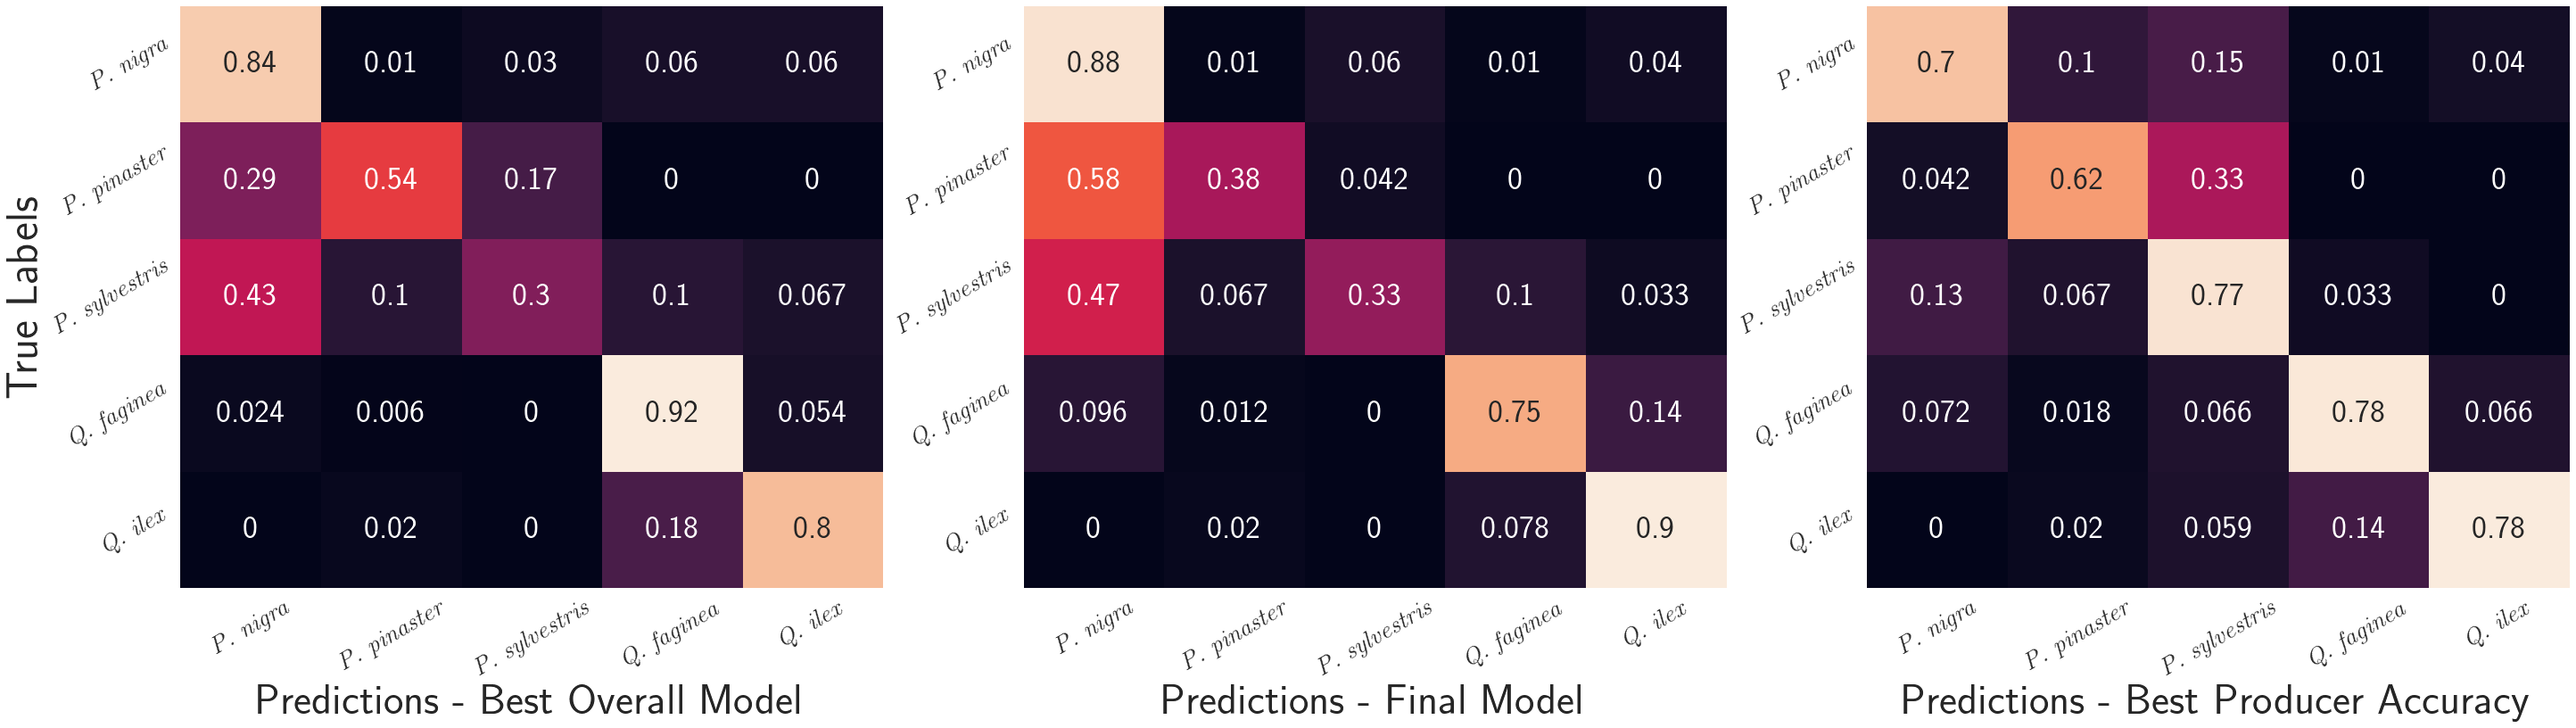

In [5]:
fig, ax = plt.subplots(1,3, figsize=(48,12))

tickFont = 28
axFont = 48
annotFont = 36

print(val_species)
val_species = ['\it{P. nigra}', '\it{P. pinaster}', '\it{P. sylvestris}', '\it{Q. faginea}', '\it{Q. ilex}']

cm1 = confusion_matrix(labels_b.cpu(), predictions_b.cpu(), normalize='true')
hm1 = sns.heatmap(cm1, annot=True, ax=ax[0], cbar=False, annot_kws={"fontsize":annotFont})
hm1.set_xticklabels(val_species, fontsize=tickFont, style = 'italic')
ax[0].set_yticklabels(val_species, fontsize=tickFont)
hm1.set_ylabel('True Labels', fontsize=axFont+2)
hm1.set_xlabel('Predictions - Best Overall Model', fontsize=axFont)




cm2 = confusion_matrix(labels_c.cpu(), predictions_c.cpu(), normalize='true')
hm2 = sns.heatmap(cm2, annot=True, ax=ax[1], cbar=False, annot_kws={"fontsize":annotFont})
hm2.set_xticklabels(val_species, fontsize=tickFont)
hm2.set_yticklabels(val_species, fontsize=tickFont)
hm2.set_ylabel('', fontsize=axFont)
hm2.set_xlabel('Predictions - Final Model', fontsize=axFont)

cm3 = confusion_matrix(labels_p.cpu(), predictions_p.cpu(), normalize='true')
hm3 = sns.heatmap(cm3, annot=True, ax=ax[2], cbar=False, annot_kws={"fontsize":annotFont})
hm3.set_xticklabels(val_species, fontsize=tickFont)
hm3.set_yticklabels(val_species, fontsize=tickFont)
hm3.set_ylabel('', fontsize=axFont)
hm3.set_xlabel('Predictions - Best Producer Accuracy', fontsize=axFont)

for axs in ax:
    for tick in axs.get_xticklabels(): 
        tick.set(rotation=30)
        
    for tick in axs.get_yticklabels(): 
        tick.set(rotation=30)
        

    

fig.savefig('conf.png', bbox_inches='tight')

['\\it{P. nigra}', '\\it{P. pinaster}', '\\it{P. sylvestris}', '\\it{Q. faginea}', '\\it{Q. ilex}']


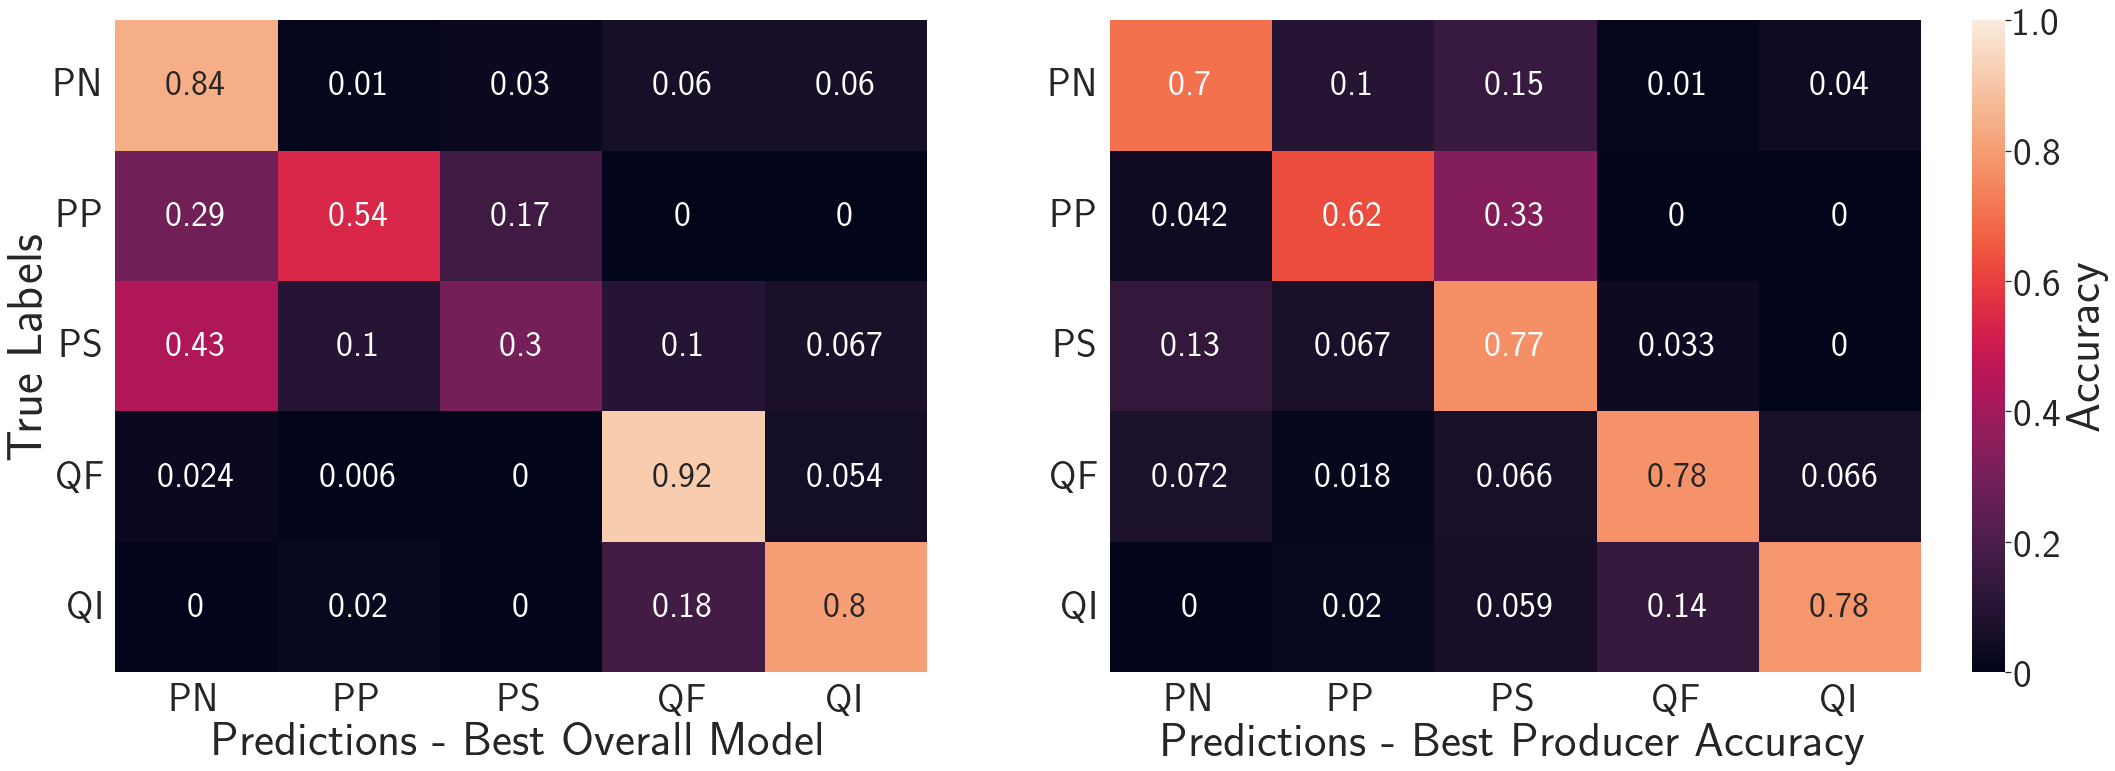

In [6]:
fig, ax = plt.subplots(1,2, figsize=(36,12), gridspec_kw={'width_ratios': [0.8, 1]})

tickFont = 40
axFont = 48
annotFont = 36

print(val_species)
val_species = ['PN', 'PP', 'PS', 'QF', 'QI']

cm1 = confusion_matrix(labels_b.cpu(), predictions_b.cpu(), normalize='true')
hm1 = sns.heatmap(cm1, annot=True, ax=ax[0], cbar=False, annot_kws={"fontsize":annotFont}, vmin=0, vmax=1)
hm1.set_xticklabels(val_species, fontsize=tickFont, style = 'italic')
ax[0].set_yticklabels(val_species, fontsize=tickFont)
hm1.set_ylabel('True Labels', fontsize=axFont+2)
hm1.set_xlabel('Predictions - Best Overall Model', fontsize=axFont)

#cm2 = confusion_matrix(labels_c.cpu(), predictions_c.cpu(), normalize='true')
#hm2 = sns.heatmap(cm2, annot=True, ax=ax[1], cbar=False, annot_kws={"fontsize":annotFont})
#hm2.set_xticklabels(val_species, fontsize=tickFont)
#hm2.set_yticklabels(val_species, fontsize=tickFont)
#hm2.set_ylabel('', fontsize=axFont)
#hm2.set_xlabel('Predictions - Final Model', fontsize=axFont)

cm3 = confusion_matrix(labels_p.cpu(), predictions_p.cpu(), normalize='true')
hm3 = sns.heatmap(cm3, annot=True, ax=ax[1], cbar=True, annot_kws={"fontsize":annotFont}, cbar_kws={'label': 'Accuracy'}, vmin=0, vmax=1)
hm3.set_xticklabels(val_species, fontsize=tickFont)
hm3.set_yticklabels(val_species, fontsize=tickFont)
hm3.set_ylabel('', fontsize=axFont)
hm3.set_xlabel('Predictions - Best Producer Accuracy', fontsize=axFont)

for axs in ax:
    for tick in axs.get_xticklabels(): 
        tick.set(rotation=0)
        
    for tick in axs.get_yticklabels(): 
        tick.set(rotation=0)
        
fig.axes[-1].yaxis.label.set_size(axFont)
cbar = ax[-1].collections[0].colorbar
cbar.set_ticks([0,0.2,0.4,0.6,0.8,1])
fig.axes[-1].set_yticklabels(['0','0.2','0.4','0.6','0.8','1.0'], fontsize=tickFont)       

    

fig.savefig('conf2.png', bbox_inches='tight')

# Multi-stem Accuracy ===========

In [7]:
data = torch.load('multistem_tree_points.pt')
model_dir = 'models/clean-basilisk-76_best'

params = {
        "dataset_type":type(data),
        "batch_size":128,
        "validation_split":.2,
        "shuffle_dataset":True,
        "random_seed":0,
        "learning_rate":[0.0005, 100, 0.5],  #[init, step_size, gamma] for scheduler
        "momentum":0.9, #Only used for sgd
        "epochs":300,
        "loss_fn":"smooth-loss",
        "optimizer":"adam",
        "voting":"None",
        "train_sampler":"balanced",

        "model":"SimpleView",

        "image_dim":256,
        "camera_fov_deg":90,
        "f":1,
        "camera_dist":1.4,
        "depth_averaging":"min",
        "soft_min_k":50,
        "num_views":6,

        "transforms":['none'],
        "min_rotation":0,
        "max_rotation":2*np.pi,
        "min_translation":0,
        "max_translation":0.5,
        "jitter_std":3e-5, 

        "species":["QUEFAG", "PINNIG", "QUEILE", "PINSYL", "PINPIN"],
        "data_resolution":"2.5cm"
    }

data.set_params(image_dim = params["image_dim"],
                    camera_fov_deg = params["camera_fov_deg"],
                    f = params["f"],
                    camera_dist = params["camera_dist"],
                    soft_min_k = params["soft_min_k"],
                    transforms = params["transforms"],
                    min_rotation = params["min_rotation"],
                    max_rotation = params["max_rotation"],
                    min_translation = params["min_translation"],
                    max_translation = params["max_translation"],
                    jitter_std = params["jitter_std"]
                    )

model = SimpleView(
            num_views=params["num_views"],
            num_classes=len(params["species"])
            )

model.load_state_dict(torch.load(model_dir))

dataset='test'

val_indices = list(np.load(f'indices/new_{dataset}_indices_{params["random_seed"]}.npy'))
val_indices = [int(vi) for vi in val_indices]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for specie in list(set(data.species) - set(params["species"])):
    print("Removing: {}".format(specie))
    data.remove_species(specie)

    data.set_params(transforms=['none'])

Removing: JUNIPE
Removing: QUERCUS
Removing: NA
Removing: DEAD


In [15]:
is_multistem = data.multistem[val_indices]

#Fish out multi-stem labels, predictions
labels_b_multistem = labels_b[is_multistem==1].cpu()
predictions_b_multistem = predictions_b[is_multistem==1].cpu()
                                
labels_p_multistem = labels_p[is_multistem==1].cpu()
predictions_p_multistem = predictions_p[is_multistem==1].cpu()
           
                                        
#Fish out single-stem labels, predictions
labels_b_singlestem = labels_b[is_multistem==0].cpu()
predictions_b_singlestem = predictions_b[is_multistem==0].cpu()
                                
labels_p_singlestem = labels_p[is_multistem==0].cpu()
predictions_p_singlestem = predictions_p[is_multistem==0].cpu()

['PN', 'PP', 'PS', 'QF', 'QI']


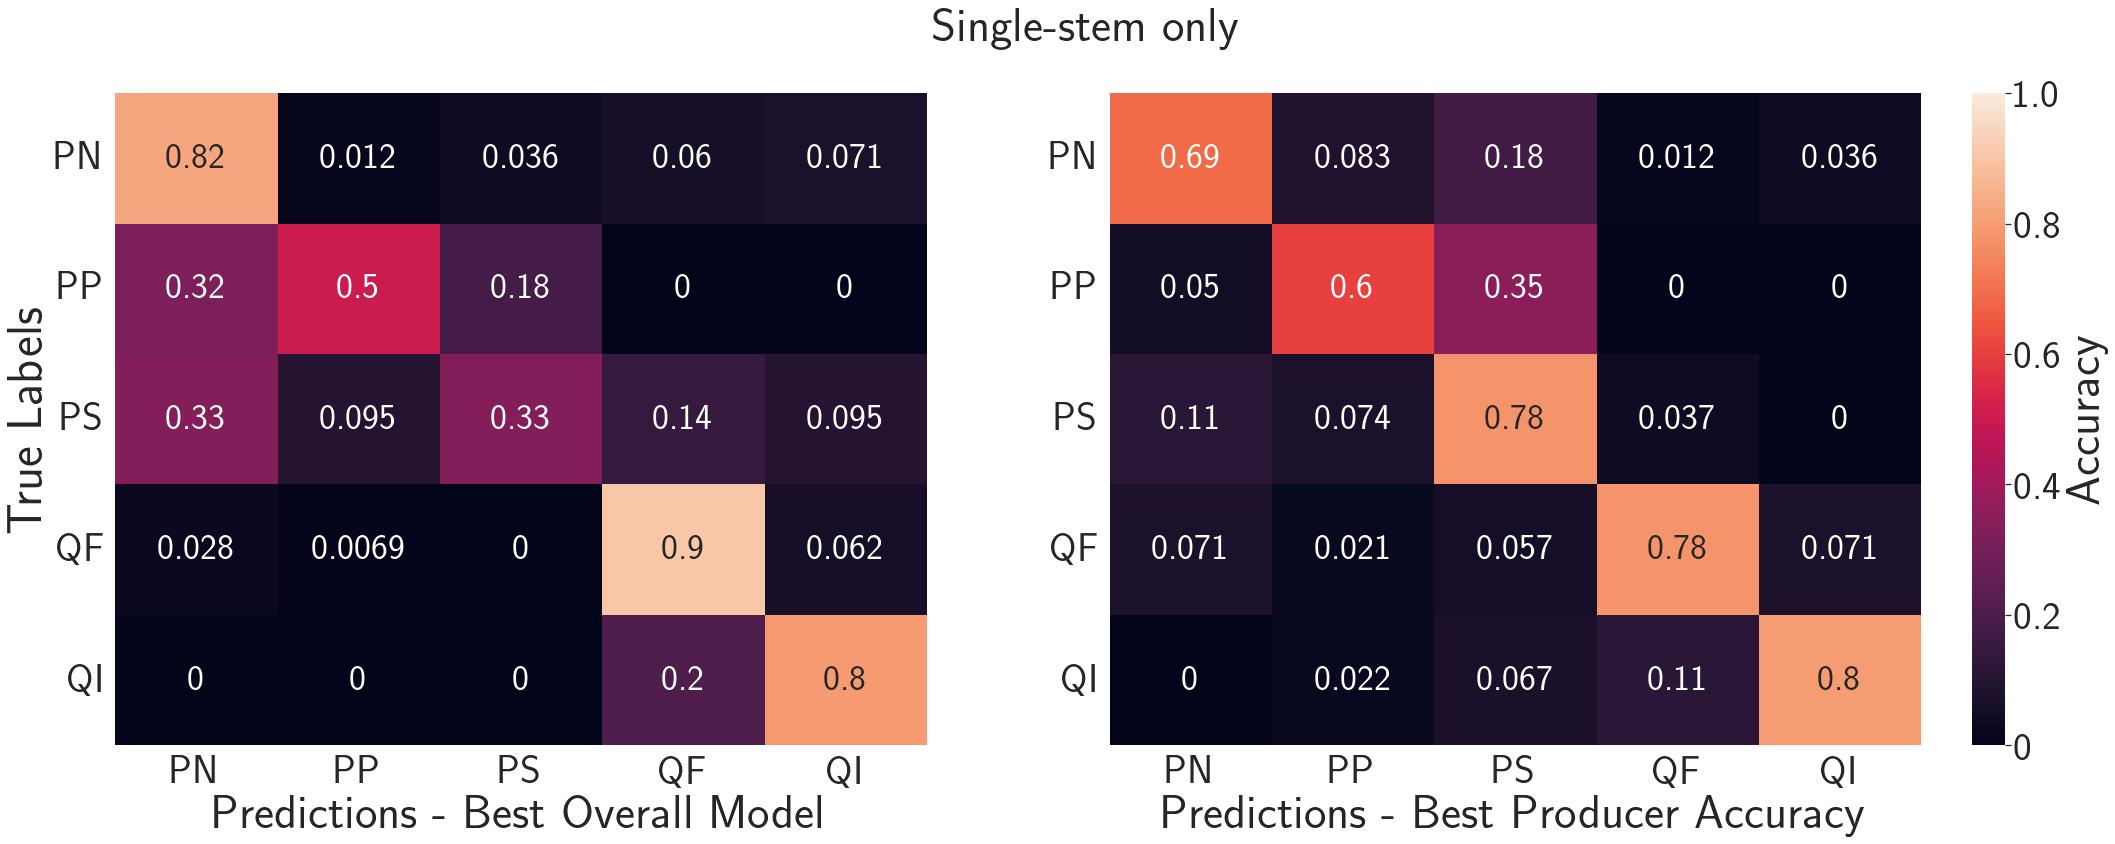

In [16]:
fig, ax = plt.subplots(1,2, figsize=(36,12), gridspec_kw={'width_ratios': [0.8, 1]})

tickFont = 40
axFont = 48
annotFont = 36

print(val_species)
val_species = ['PN', 'PP', 'PS', 'QF', 'QI']

cm1 = confusion_matrix(labels_b_singlestem, predictions_b_singlestem, normalize='true')
hm1 = sns.heatmap(cm1, annot=True, ax=ax[0], cbar=False, annot_kws={"fontsize":annotFont}, vmin=0, vmax=1)
hm1.set_xticklabels(val_species, fontsize=tickFont, style = 'italic')
ax[0].set_yticklabels(val_species, fontsize=tickFont)
hm1.set_ylabel('True Labels', fontsize=axFont+2)
hm1.set_xlabel('Predictions - Best Overall Model', fontsize=axFont)


cm3 = confusion_matrix(labels_p_singlestem, predictions_p_singlestem, normalize='true')
hm3 = sns.heatmap(cm3, annot=True, ax=ax[1], cbar=True, annot_kws={"fontsize":annotFont}, cbar_kws={'label': 'Accuracy'}, vmin=0, vmax=1)
hm3.set_xticklabels(val_species, fontsize=tickFont)
hm3.set_yticklabels(val_species, fontsize=tickFont)
hm3.set_ylabel('', fontsize=axFont)
hm3.set_xlabel('Predictions - Best Producer Accuracy', fontsize=axFont)

for axs in ax:
    for tick in axs.get_xticklabels(): 
        tick.set(rotation=0)
        
    for tick in axs.get_yticklabels(): 
        tick.set(rotation=0)
        
fig.axes[-1].yaxis.label.set_size(axFont)
cbar = ax[-1].collections[0].colorbar
cbar.set_ticks([0,0.2,0.4,0.6,0.8,1])
fig.axes[-1].set_yticklabels(['0','0.2','0.4','0.6','0.8','1.0'], fontsize=tickFont)      

fig.suptitle('Single-stem only', fontsize=axFont)

    
fig.savefig('conf2.png', bbox_inches='tight')

['PN', 'PP', 'PS', 'QF', 'QI']


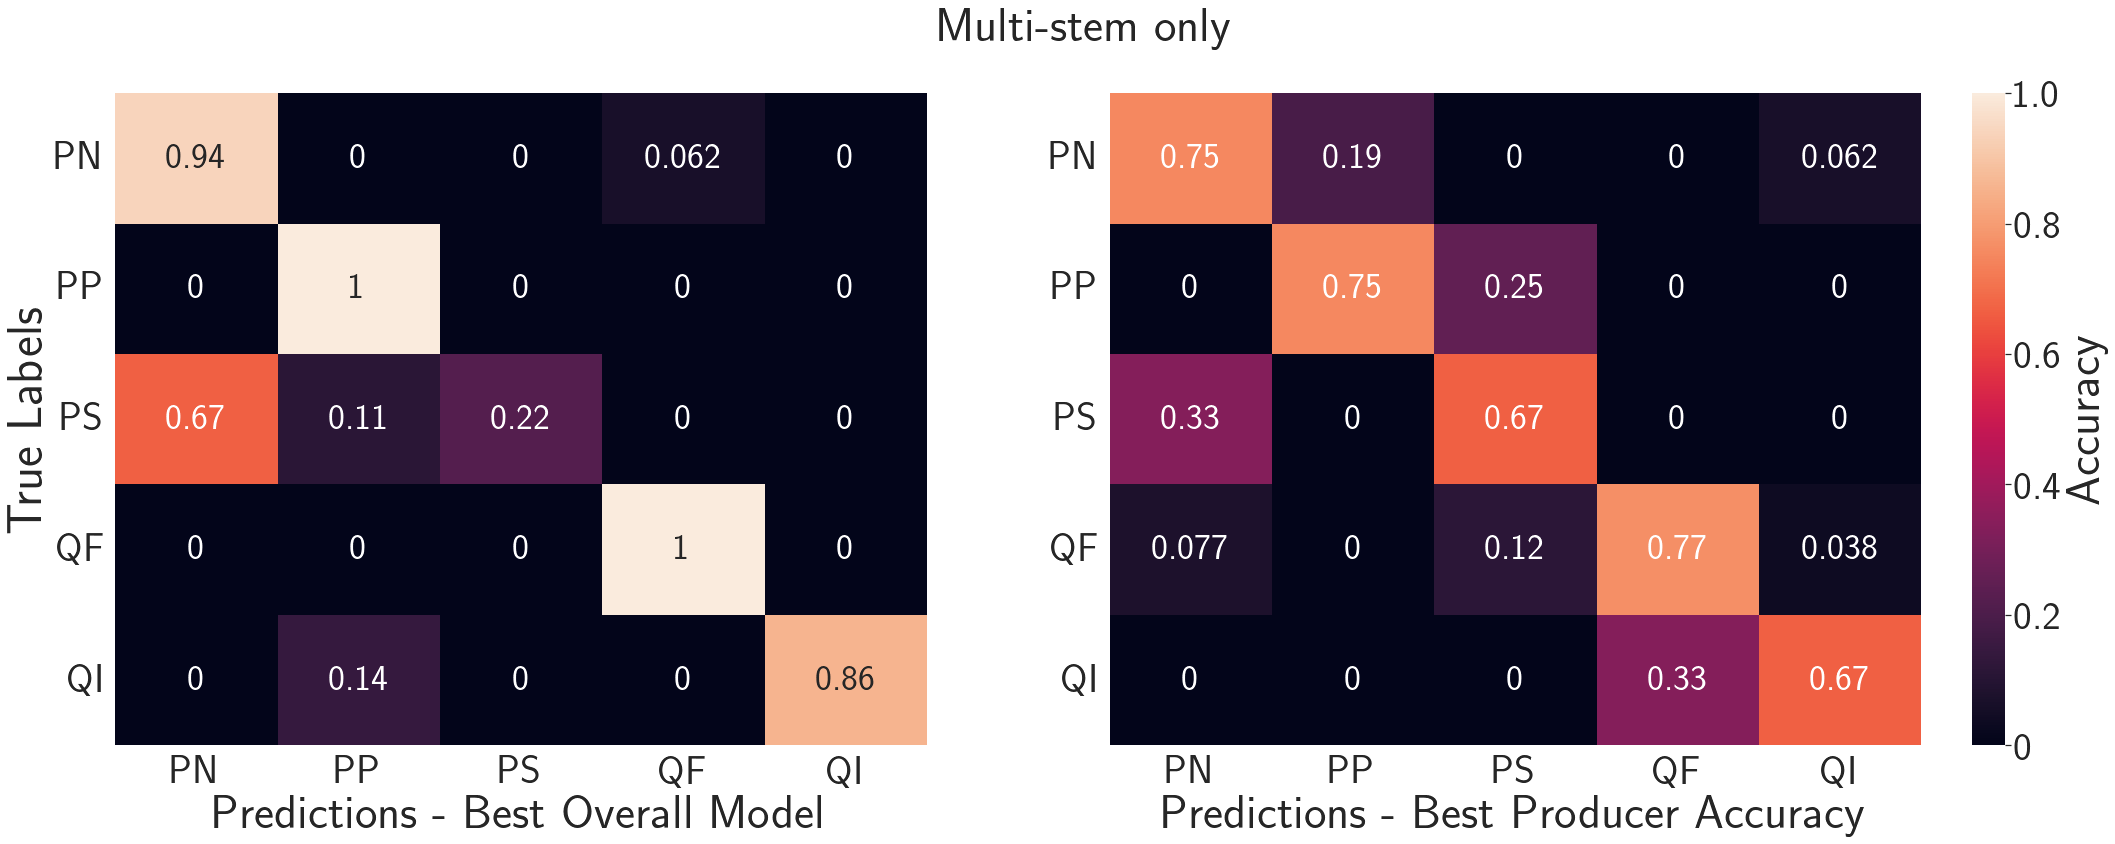

In [17]:
fig, ax = plt.subplots(1,2, figsize=(36,12), gridspec_kw={'width_ratios': [0.8, 1]})

tickFont = 40
axFont = 48
annotFont = 36

print(val_species)
val_species = ['PN', 'PP', 'PS', 'QF', 'QI']

cm1 = confusion_matrix(labels_b_multistem, predictions_b_multistem, normalize='true')
hm1 = sns.heatmap(cm1, annot=True, ax=ax[0], cbar=False, annot_kws={"fontsize":annotFont}, vmin=0, vmax=1)
hm1.set_xticklabels(val_species, fontsize=tickFont, style = 'italic')
ax[0].set_yticklabels(val_species, fontsize=tickFont)
hm1.set_ylabel('True Labels', fontsize=axFont+2)
hm1.set_xlabel('Predictions - Best Overall Model', fontsize=axFont)


cm3 = confusion_matrix(labels_p_multistem, predictions_p_multistem, normalize='true')
hm3 = sns.heatmap(cm3, annot=True, ax=ax[1], cbar=True, annot_kws={"fontsize":annotFont}, cbar_kws={'label': 'Accuracy'}, vmin=0, vmax=1)
hm3.set_xticklabels(val_species, fontsize=tickFont)
hm3.set_yticklabels(val_species, fontsize=tickFont)
hm3.set_ylabel('', fontsize=axFont)
hm3.set_xlabel('Predictions - Best Producer Accuracy', fontsize=axFont)

for axs in ax:
    for tick in axs.get_xticklabels(): 
        tick.set(rotation=0)
        
    for tick in axs.get_yticklabels(): 
        tick.set(rotation=0)
        
fig.axes[-1].yaxis.label.set_size(axFont)
cbar = ax[-1].collections[0].colorbar
cbar.set_ticks([0,0.2,0.4,0.6,0.8,1])
fig.axes[-1].set_yticklabels(['0','0.2','0.4','0.6','0.8','1.0'], fontsize=tickFont)      

fig.suptitle('Multi-stem only', fontsize=axFont)

    
fig.savefig('conf2.png', bbox_inches='tight')

In [11]:
len(labels_b_multistem)

57

In [26]:
labels_b

tensor([4., 3., 2., 3., 3., 0., 3., 0., 3., 0., 0., 4., 4., 0., 1., 3., 4., 3.,
        2., 0., 3., 3., 3., 3., 0., 3., 3., 3., 3., 3., 4., 2., 4., 3., 3., 3.,
        3., 0., 3., 3., 0., 2., 0., 1., 0., 3., 4., 2., 3., 0., 3., 3., 0., 3.,
        0., 3., 3., 0., 1., 0., 1., 3., 3., 4., 3., 3., 2., 3., 0., 0., 3., 0.,
        4., 2., 1., 2., 4., 0., 4., 0., 4., 3., 3., 3., 4., 0., 3., 3., 3., 3.,
        1., 0., 1., 4., 3., 3., 3., 4., 3., 4., 4., 3., 3., 0., 3., 2., 1., 0.,
        3., 2., 2., 0., 0., 0., 3., 4., 0., 2., 0., 3., 0., 0., 0., 4., 1., 0.,
        3., 3., 0., 3., 4., 3., 3., 0., 0., 0., 3., 3., 2., 2., 3., 4., 0., 1.,
        3., 3., 3., 0., 4., 0., 0., 3., 3., 3., 3., 3., 0., 3., 3., 3., 3., 3.,
        4., 4., 3., 3., 4., 3., 4., 3., 3., 3., 0., 0., 3., 0., 3., 0., 3., 0.,
        4., 2., 3., 0., 3., 2., 3., 3., 0., 3., 3., 2., 0., 3., 3., 3., 4., 4.,
        2., 4., 4., 1., 0., 1., 3., 0., 0., 2., 0., 3., 3., 3., 3., 3., 3., 0.,
        3., 1., 1., 0., 4., 2., 3., 1., 

2478

In [18]:
print([val_species[x] for x in labels_b_multistem.int()])

['QI', 'PS', 'QF', 'PN', 'QF', 'QF', 'QI', 'PN', 'QF', 'QI', 'PP', 'PN', 'QI', 'QF', 'QF', 'QF', 'QI', 'QI', 'QF', 'QF', 'QF', 'PP', 'PS', 'PN', 'QF', 'PS', 'PS', 'QI', 'PS', 'QF', 'QF', 'PS', 'QI', 'QF', 'QF', 'QF', 'QF', 'PN', 'PS', 'QF', 'QI', 'QF', 'PP', 'QF', 'PN', 'PS', 'PN', 'QF', 'QF', 'QF', 'PP', 'PN', 'QF', 'QF', 'QF', 'PN', 'PS']


In [27]:
labels_b

tensor([4., 3., 2., 3., 3., 0., 3., 0., 3., 0., 0., 4., 4., 0., 1., 3., 4., 3.,
        2., 0., 3., 3., 3., 3., 0., 3., 3., 3., 3., 3., 4., 2., 4., 3., 3., 3.,
        3., 0., 3., 3., 0., 2., 0., 1., 0., 3., 4., 2., 3., 0., 3., 3., 0., 3.,
        0., 3., 3., 0., 1., 0., 1., 3., 3., 4., 3., 3., 2., 3., 0., 0., 3., 0.,
        4., 2., 1., 2., 4., 0., 4., 0., 4., 3., 3., 3., 4., 0., 3., 3., 3., 3.,
        1., 0., 1., 4., 3., 3., 3., 4., 3., 4., 4., 3., 3., 0., 3., 2., 1., 0.,
        3., 2., 2., 0., 0., 0., 3., 4., 0., 2., 0., 3., 0., 0., 0., 4., 1., 0.,
        3., 3., 0., 3., 4., 3., 3., 0., 0., 0., 3., 3., 2., 2., 3., 4., 0., 1.,
        3., 3., 3., 0., 4., 0., 0., 3., 3., 3., 3., 3., 0., 3., 3., 3., 3., 3.,
        4., 4., 3., 3., 4., 3., 4., 3., 3., 3., 0., 0., 3., 0., 3., 0., 3., 0.,
        4., 2., 3., 0., 3., 2., 3., 3., 0., 3., 3., 2., 0., 3., 3., 3., 4., 4.,
        2., 4., 4., 1., 0., 1., 3., 0., 0., 2., 0., 3., 3., 3., 3., 3., 3., 0.,
        3., 1., 1., 0., 4., 2., 3., 1., 

In [28]:
data.multistem[val_indices]

tensor([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [35]:
data.multistem[val_indices]

tensor([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [56]:
data.meta_frame

,old_id,id,sp,out_of_bounds,multistem,dead,qa,Unnamed: 7
1,alt01_002,alt01_2,QUEFAG,1,0,0,1,
2,alt01_004,alt01_4,QUEFAG,1,1,0,1,
3,alt01_005,alt01_5,QUEFAG,1,0,0,1,
4,alt01_006,alt01_6,PINSYL,1,0,0,1,
5,alt01_007,alt01_7,QUEFAG,1,0,0,1,
...,...,...,...,...,...,...,...,...
2480,cue06_017,cue06_17,PINPIN,1,0,0,1,
2481,cue06_018,cue06_18,PINPIN,1,0,0,1,
2482,cue06_019,cue06_19,PINPIN,1,0,0,1,
2483,cue06_020,cue06_20,PINSYL,1,1,0,1,


In [61]:
data.labels

tensor([0, 3, 3,  ..., 4, 0, 3])

In [62]:
frame_labels = [data.species.index(x) for x in list(data.meta_frame['sp'])]

ValueError: 'DEAD' is not in list

In [66]:
data.meta_frame.sp.unique()

array(['QUEFAG', 'PINSYL', 'PINNIG', 'DEAD', 'QUEILE', 'NA', 'QUERCUS',
       'JUNIPE', 'PINPIN'], dtype=object)

In [ ]:
data2.labels

# Rotation Voting ===========

## Sweep

In [7]:
accuracies = {}
rotations = [64]
max_rotation = 0.5*np.pi

for model in ["best"]:
    accuracies[model] = {"soft":[],"hard":[]}
    for num_rotations in rotations:
        print(f"{model}_{num_rotations}")
        soft_predictions, hard_predictions, labels, species = utils.rot_vot_from_dirs(dataset_dir,
                                                                               model_dir=f"{model_dir}_{model}",
                                                                               num_rotations=num_rotations,
                                                                               max_rotation=max_rotation)
        accuracies[model]["soft"].append(accuracy_score(labels.cpu(), soft_predictions.cpu()))
        accuracies[model]["hard"].append(accuracy_score(labels.cpu(), hard_predictions.cpu()))

if None:
    with open(f'rot_{max_rotation:.2f}_acc.pickle', 'wb') as handle:
        pickle.dump(accuracies, handle, protocol=pickle.HIGHEST_PROTOCOL)

best_64
Removing: NA
Removing: DEAD
Removing: JUNIPE
Removing: QUERCUS


['P. Nigra', 'P. Pinaster', 'P. Sylvestris', 'Q. Faginea', 'Q. Ilex']


Text(0.5, 57.75875865893524, 'Predictions - Best Overall w/ 64 Hard Rotation Votes')

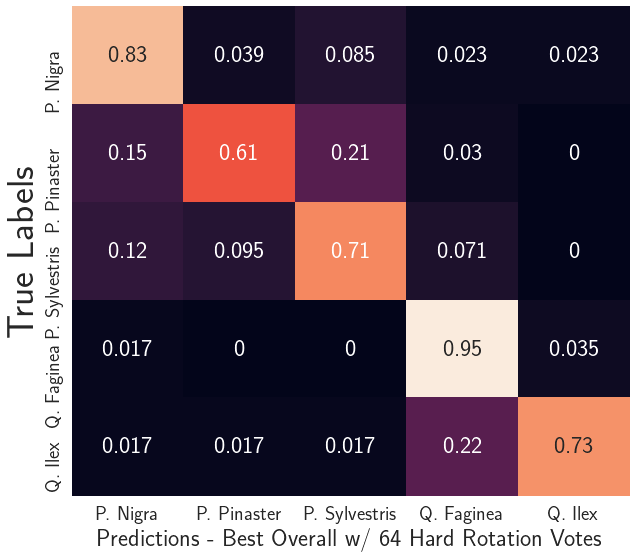

In [11]:
fig_rot, ax_rot = plt.subplots(figsize=(10,9))

tickFont = 20
axFont = 36
annotFont = 24

print(val_species)
val_species = ['P. Nigra', 'P. Pinaster', 'P. Sylvestris', 'Q. Faginea', 'Q. Ilex']

cm_rot = confusion_matrix(labels.cpu(), hard_predictions.cpu(), normalize='true')
hm_rot = sns.heatmap(cm_rot, annot=True, ax=ax_rot, cbar=False, annot_kws={"fontsize":annotFont})
hm_rot.set_xticklabels(val_species, fontsize=tickFont)
ax_rot.set_yticklabels(val_species, fontsize=tickFont)
hm_rot.set_ylabel('True Labels', fontsize=axFont+2)
hm_rot.set_xlabel('Predictions - Best Overall w/ 64 Hard Rotation Votes', fontsize=axFont-12)

In [12]:
accuracies_tmp = {'best': {'soft': [0.8303030303030303,
   0.8363636363636363,
   0.8383838383838383,
   0.8464646464646465,
   0.8444444444444444,
   0.8444444444444444,
   0.8464646464646465],
  'hard': [0.8303030303030303,
   0.8262626262626263,
   0.8222222222222222,
   0.8444444444444444,
   0.8464646464646465,
   0.8464646464646465,
   0.8484848484848485]},
 'converged': {'soft': [0.8101010101010101,
   0.8121212121212121,
   0.8101010101010101,
   0.8121212121212121,
   0.8181818181818182,
   0.8161616161616162,
   0.8161616161616162],
  'hard': [0.8101010101010101,
   0.806060606060606,
   0.8121212121212121,
   0.8181818181818182,
   0.8141414141414142,
   0.8181818181818182,
   0.8181818181818182]},
 'best_prod': {'soft': [0.8222222222222222,
   0.8121212121212121,
   0.8181818181818182,
   0.8161616161616162,
   0.8141414141414142,
   0.8121212121212121,
   0.8161616161616162],
  'hard': [0.8222222222222222,
   0.8242424242424242,
   0.8161616161616162,
   0.8101010101010101,
   0.8161616161616162,
   0.8161616161616162,
   0.8222222222222222]}}

In [4]:
import pickle
with open('rot_acc.pkl', 'wb') as handle:
    acc = pickle.load('rot_acc.pkl')

TypeError: file must have 'read' and 'readline' attributes